In [7]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np

class MultiFolderImageDataGenerator(Sequence):
    def __init__(self, csv_paths, image_dirs, batch_size, target_size=(180, 180)):
        self.batch_size = batch_size
        self.target_size = target_size
        self.image_paths = []
        self.labels = []

        for csv_path, image_dir in zip(csv_paths, image_dirs):
            csv_data = pd.read_csv(csv_path)
            
            #Generate a list of paths to images
            image_paths = [os.path.join(image_dir, fname) for fname in csv_data['filename']]
            self.image_paths.extend(image_paths)
            self.labels.extend(csv_data['age'].values)

    def __len__(self):
        return int(len(self.image_paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size
        batch_image_paths = self.image_paths[batch_start:batch_end]
        batch_labels = np.array(self.labels[batch_start:batch_end])

        batch_images = np.zeros((self.batch_size, *self.target_size, 3), dtype=np.float32)

        #Image loading and normalization
        for i, img_path in enumerate(batch_image_paths):
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0
            batch_images[i] = img_array

        return batch_images, batch_labels


batch_size = 600
target_size = (180, 180)

train_csv = '/kaggle/input/morph/Dataset/Index/Train.csv'
train_images = '/kaggle/input/morph/Dataset/Images/Train'
test_csv = '/kaggle/input/morph/Dataset/Index/Test.csv'
test_images = '/kaggle/input/morph/Dataset/Images/Test'
validation_csv = '/kaggle/input/morph/Dataset/Index/Validation.csv'
validation_images = '/kaggle/input/morph/Dataset/Images/Validation'

#Create generators
combined_train_generator = MultiFolderImageDataGenerator(
    csv_paths=[train_csv, test_csv],
    image_dirs=[train_images, test_images],
    batch_size=batch_size,
    target_size=target_size
)

validation_generator = MultiFolderImageDataGenerator(
    csv_paths=[validation_csv],
    image_dirs=[validation_images],
    batch_size=batch_size,
    target_size=target_size
)

# **Data visualization**

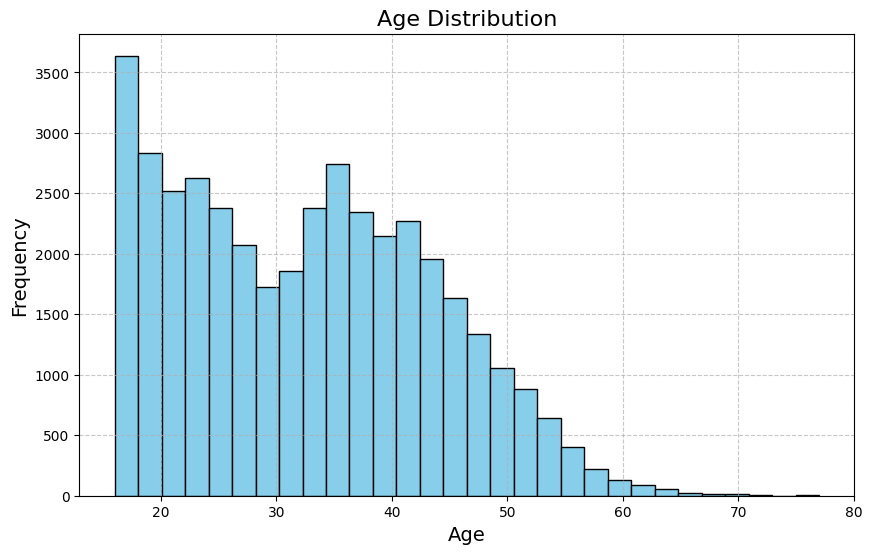

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


train_csv = '/kaggle/input/morph/Dataset/Index/Train.csv'

#Loading data
try:
    data = pd.read_csv(train_csv)
except FileNotFoundError:
    print("Файл не найден. Убедитесь, что путь указан правильно.")
    raise

ages = data['age'] + 16

#Draw the data on the chart
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# **Model training**

In [3]:
%%time

model = tf.keras.Sequential([
    Input(shape=(180, 180, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(),
    loss='mse',
    metrics=['mae']
)



#ModelCheckpoint callback
checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'best_model_1.keras')
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)


#TensorBoard logs
log_dir = '/kaggle/working/train_logs/model_1_logs'
os.makedirs(log_dir, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir)


#Model training
history = model.fit(
    combined_train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[tensorboard, model_checkpoint]
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733865907.056993      90 service.cc:145] XLA service 0x7cfd80006b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733865907.057075      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733865907.057082      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733865933.742094      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 174.4101 - mae: 10.6899

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_mae improved from inf to 9.82961, saving model to /kaggle/working/checkpoints/best_model_1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - loss: 174.2023 - mae: 10.6857 - val_loss: 138.7409 - val_mae: 9.8296
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - loss: 210.5779 - mae: 11.3426
Epoch 2: val_mae did not improve from 9.82961
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - loss: 210.5105 - mae: 11.3439 - val_loss: 239.5360 - val_mae: 12.2792
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - loss: 190.2092 - mae: 11.4564
Epoch 3: val_mae improved from 9.82961 to 9.68013, saving model to /kaggle/working/checkpoints/best_model_1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 189.8331 - mae: 11.4450 - val_loss: 136.3740 - val_mae: 9.6801
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - loss: 147.2672 - mae: 10.1830
Epoch 4: val_mae improved from 9.68013 to 9.28988, saving model to /kaggle/working/checkpoints/best_model_1.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 

In [4]:
#Save the model
model_path = '/kaggle/working/models/age_detection_model_1.h5'
model.save(model_path)
print(f"Модель сохранена по пути: {model_path}")

Модель сохранена по пути: /kaggle/working/models/age_detection_model_1.h5


In [6]:
import shutil
shutil.make_archive('/kaggle/working/', 'zip', '/kaggle/working/')


'/kaggle/working/.zip'

In [7]:
!zip -r /kaggle/working/working_dir.zip /kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/output.zip (stored 0%)
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/best_model_1.keras (deflated 26%)
  adding: kaggle/working/.zip (stored 0%)
  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/age_detection_model_1.h5 (deflated 26%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/train_logs/ (stored 0%)
  adding: kaggle/working/train_logs/model_1_logs/ (stored 0%)
  adding: kaggle/working/train_logs/model_1_logs/train/ (stored 0%)
  adding: kaggle/working/train_logs/model_1_logs/train/events.out.tfevents.1733865874.8c507d710ece.23.0.v2 (deflated 87%)
  adding: kaggle/working/train_logs/model_1_logs/validation/ (stored 0%)
  adding: kaggle/working/train_logs/model_1_logs/validation/events.out.tfevents.1733866181.8c507d710ece.23.1.v2 (deflated 77%)


# **Using the model**

In [5]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/age_regression_best_model/tensorflow2/default/1/best_model_1.keras')


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step
MAE: 5.14
MSE: 46.07
RMSE: 6.79
R^2: 0.77


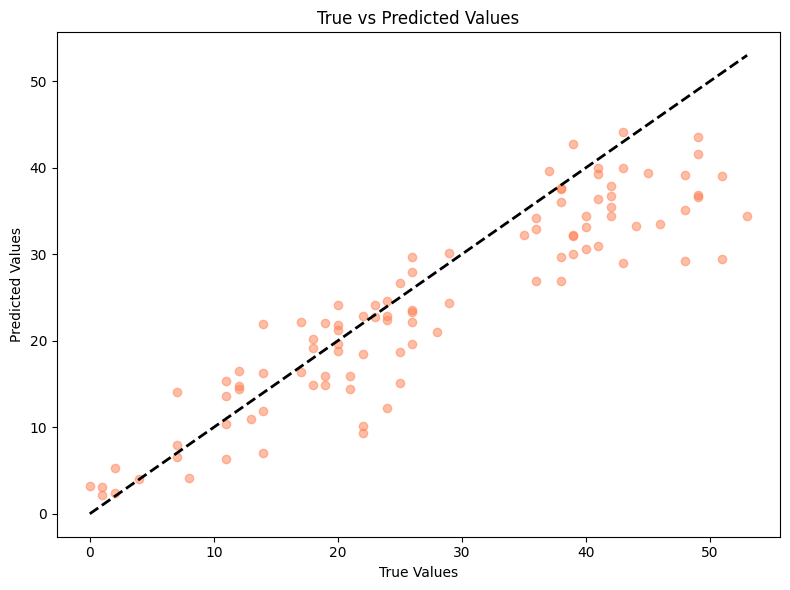

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get the first 100 data points from the validation_generator
X_val, y_val = validation_generator[0]  # first batch
y_val_all = y_val.copy()
X_val_all = X_val.copy()

# Iterate through the next batches to gather the first 100 samples
sample_count = 100
for i in range(1, len(validation_generator)):
    X_batch, y_batch = validation_generator[i]
    X_val_all = np.vstack((X_val_all, X_batch))
    y_val_all = np.hstack((y_val_all, y_batch))
    if len(y_val_all) >= sample_count:
        break

# Limit to the first 100 samples
X_val_all = X_val_all[:sample_count]
y_val_all = y_val_all[:sample_count]

# Make predictions with the model
predictions = model.predict(X_val_all)

# Calculate metrics
mae = mean_absolute_error(y_val_all, predictions)
mse = mean_squared_error(y_val_all, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_all, predictions)

# Print metrics
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Plot True Values vs Predicted Values with coral color
plt.figure(figsize=(8, 6))
plt.scatter(y_val_all, predictions, alpha=0.5, color='coral')
plt.plot([y_val_all.min(), y_val_all.max()], [y_val_all.min(), y_val_all.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.tight_layout()
plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np

X_val, y_val = validation_generator[0]

predictions = model.predict(X_val[:30])
predictions += 16
y_val = y_val[:30] + 16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


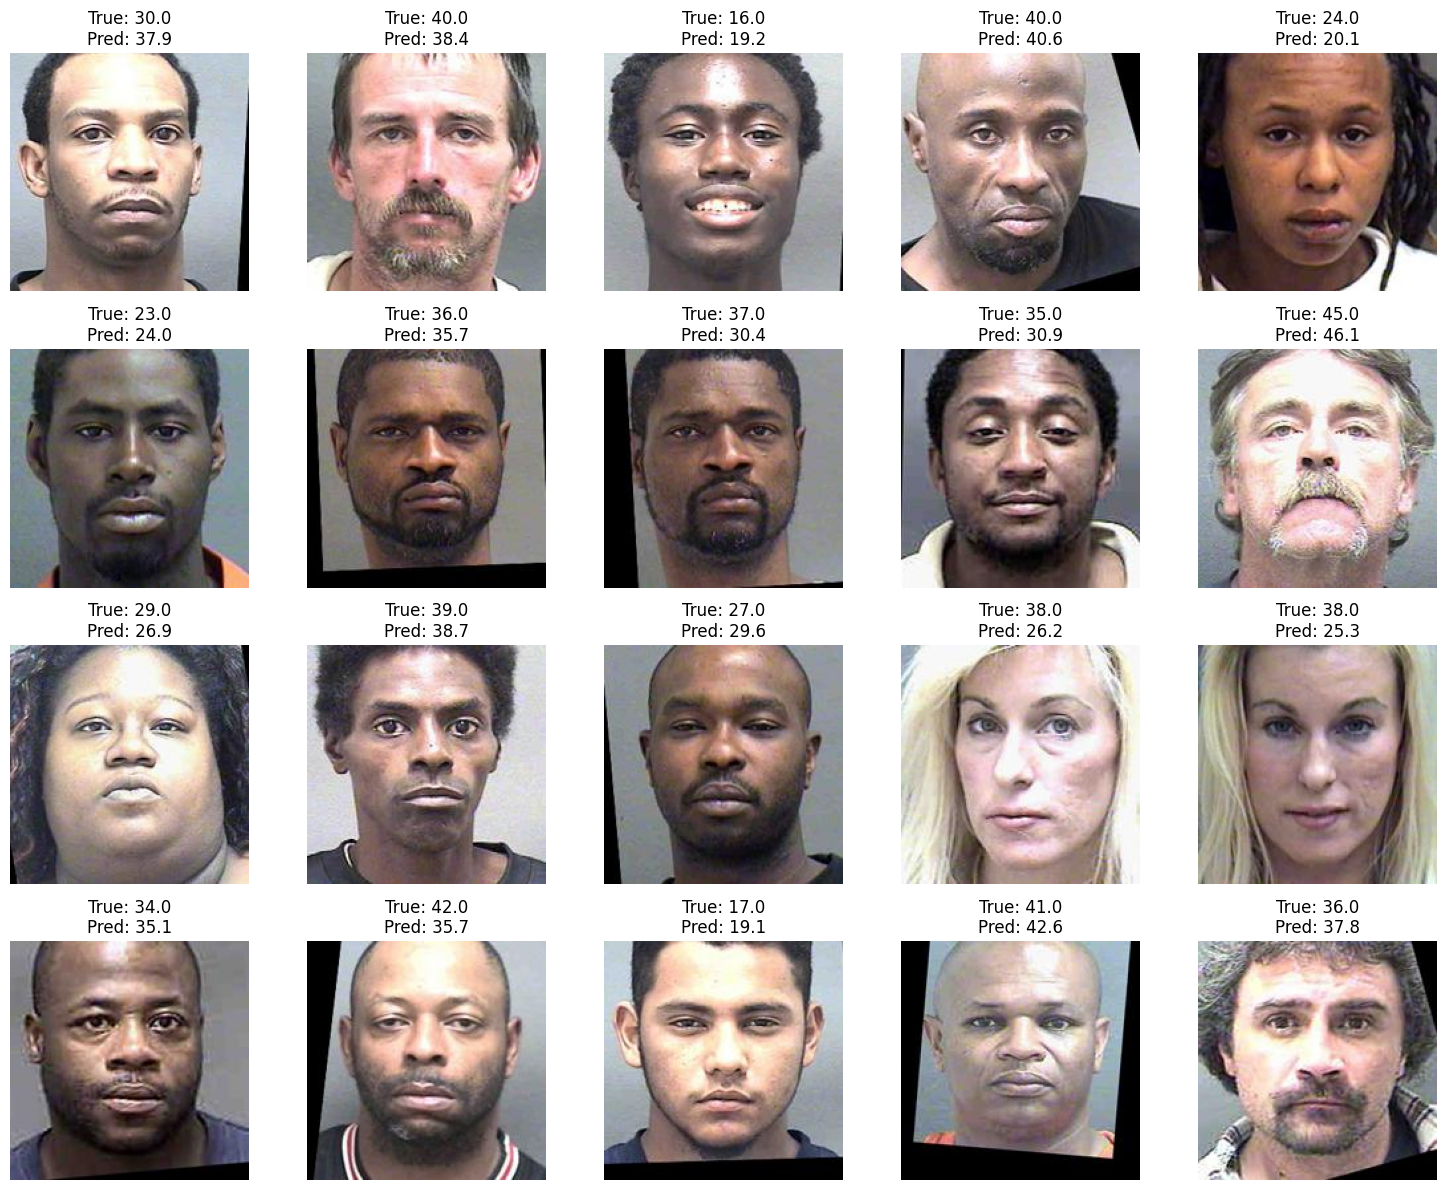

In [20]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    if i < 30:
        ax.imshow(X_val[i])
        ax.axis('off')
        
        ax.set_title(f"True: {y_val[i]:.1f}\nPred: {predictions[i][0]:.1f}")

plt.tight_layout()
plt.show()